# Uklanjanje šuma iz starih fotografija

### Baza podataka CIFAR-10
- 60 000 fotografija
- 32x32 RGB
- 10 klasa
- svaka klasa po 6 000 fotografija
- Klase:    (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
- U ovom radu klase neće biti važne


Stare fotografije oponašamo tako što fotografije iz baze prevodimo u crno-beli format i dodajemo im crno-beli šum.

Cilj nam je da detektujemo i uklonimo šum iz starih fotografija, bez obzira na to šta se na fotografiji nalazi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
import random

Učitavamo bazu

In [2]:
from keras.datasets import cifar10

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape

(50000, 1)

In [7]:
x_train[7].shape

(32, 32, 3)

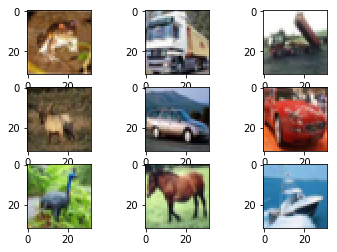

In [8]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(x_train[i])
plt.show()

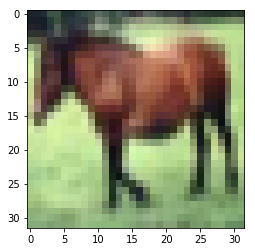

In [9]:
plt.imshow(x_train[7])

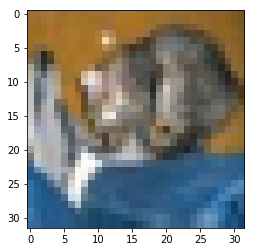

In [10]:
plt.imshow(x_test[0])

In [11]:
m = 60000

In [12]:
num_pix = 32

Spajamo podatke iz skupa za obučavanje i skupa za testiranje jer nam ne odgovara trenutna podela 50 000 : 10 000

In [13]:
img_data = np.vstack((x_train,x_test),)

In [14]:
img_data.shape

(60000, 32, 32, 3)

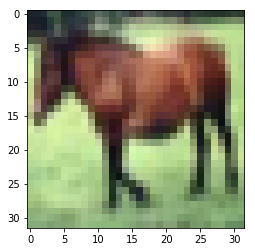

In [15]:
plt.imshow(img_data[7])

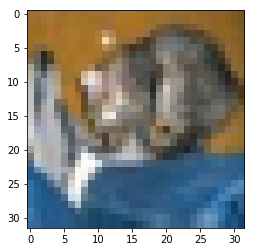

In [16]:
plt.imshow(img_data[50000])

In [17]:
img_gray = np.zeros((m, num_pix, num_pix))

In [18]:
img_gray.shape

(60000, 32, 32)

In [19]:
img_gray_noisy = np.zeros((m, num_pix, num_pix))

Prevodimo originalne fotografije u crno-beli format

In [20]:
img_gray = np.dot(img_data[...,:3], [0.299, 0.587, 0.114])

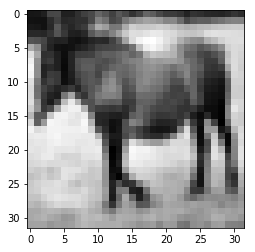

In [21]:
plt.imshow(img_gray[7], cmap = 'gray')

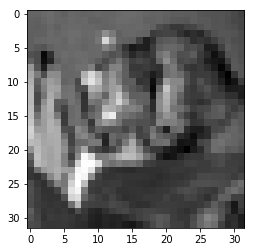

In [22]:
plt.imshow(img_gray[50000], cmap = 'gray')

Funkcija koja dodaje "salt and pepper noise" sa zadatim procentom (crnog i belog) šuma

In [23]:
def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i,j] = 0
            elif rdn > thres:
                output[i,j] = 255
            else:
                output[i,j] = image[i,j]
    return output

Slikama dodajemo 15% šuma (7,5% crno i 7,5% belo)

In [24]:
for k in range(m):
    img_gray_noisy[k] = sp_noise(img_gray[k], 0.075)

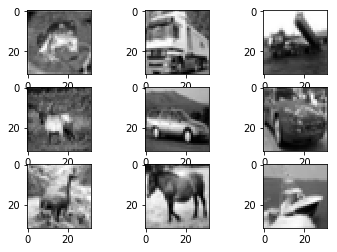

In [25]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(img_gray[i], cmap = 'gray')
plt.show()

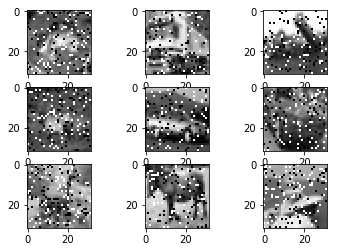

In [26]:
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(img_gray_noisy[i], cmap = 'gray')
plt.show()

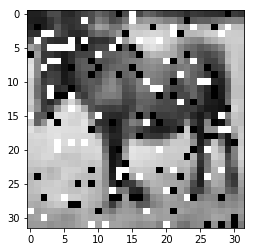

In [27]:
plt.imshow(img_gray_noisy[7], cmap = 'gray')

Funkcija koja detektuje šum tako što ispituje četiri susedna piksela (gore, dole, levo i desno) i računa minimalnu razliku.

In [28]:
def noise_detector1(image, cube_size):
    image_noise_detected = np.zeros(image.shape)
    
    for i in range((cube_size-1)//2, image.shape[0]-(cube_size-1)//2):
        for j in range((cube_size-1)//2, image.shape[1]-(cube_size-1)//2):

            vector1 = [abs(image[i,j] - image[i-1,j]),
                  abs(image[i,j] - image[i,j-1]), abs(image[i,j] - image[i,j+1]),
                  abs(image[i,j] - image[i+1,j])]
            minimum1 = np.min(vector1)
            
            if (minimum1 > 40):
                image_noise_detected[i,j] = 1
            else:
                image_noise_detected[i,j] = 0
                   
    image_noise_detected_red = image_noise_detected[((cube_size-1)//2):(image.shape[0]-(cube_size-1)//2),\
                                                    ((cube_size-1)//2):(image.shape[1]-(cube_size-1)//2)]
    Y_noise_detected = np.transpose(image_noise_detected_red).reshape((image.shape[0]-(cube_size-1))*(image.shape[1]-(cube_size-1)),1)
    return Y_noise_detected

In [29]:
noisy_img = img_gray_noisy[7].astype(int)

In [30]:
detected = noise_detector1(noisy_img,5)

Procenat detektovanog šuma

In [31]:
p = len(detected[detected==1])/len(detected)
p

0.10459183673469388

In [32]:
cube_size = 5

Matrica koja pokazuje na kojim pikselima je detektovan šum

In [33]:
C = np.transpose(detected.reshape(((num_pix-(cube_size-1)),(num_pix - (cube_size-1))))).astype(int)
C

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 

Pogledaćemo kako funkcija radi na primeru osme fotografije iz baze

In [34]:
img = img_gray_noisy[7][2:-2,2:-2].copy()

Sve piksele na kojima je detektovan šum ćemo pretvoriti u crne. Tako možemo da vidimo sve bele šumove koje funkcija nije detektovala.

In [35]:
img[C==1] = 0

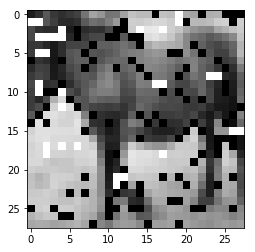

In [36]:
plt.imshow(img, cmap = 'gray')

Funkcija ne detektuje bele šumove u slučaju kada se nalaze na jedan do drugog, horizontalno ili vertikalno.

Sve piksele na kojima je detektovan šum ćemo pretvoriti u bele. Tako možemo da vidimo sve crne šumove koje funkcija nije detektovala.

In [37]:
img[C==1] = 255

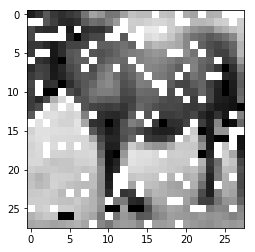

In [38]:
plt.imshow(img, cmap = 'gray')

Funkcija koja detektuje i dva šuma na susednim pikselima.

In [39]:
def noise_detector(image, cube_size):
    image_noise_detected = np.zeros(image.shape)
    
    for i in range((cube_size-1)//2, image.shape[0]-(cube_size-1)//2):
        for j in range((cube_size-1)//2, image.shape[1]-(cube_size-1)//2):

            vector1 = [abs(image[i,j] - image[i-1,j]),
                  abs(image[i,j] - image[i,j-1]), abs(image[i,j] - image[i,j+1]),
                  abs(image[i,j] - image[i+1,j])]
            minimum1 = np.min(vector1)
            vector2 = [abs(image[i,j] - image[i-1,j-1]),
                  abs(image[i,j] - image[i+1,j-1]), abs(image[i,j] - image[i-1,j+1]),
                  abs(image[i,j] - image[i+1,j+1])]
            minimum2 = np.min(vector2)
            if (minimum1 > 40) | (minimum2 > 40):
                image_noise_detected[i,j] = 1
            else:
                image_noise_detected[i,j] = 0
                   
    image_noise_detected_red = image_noise_detected[((cube_size-1)//2):(image.shape[0]-(cube_size-1)//2),\
                                                    ((cube_size-1)//2):(image.shape[1]-(cube_size-1)//2)]
    Y_noise_detected = np.transpose(image_noise_detected_red).reshape((image.shape[0]-(cube_size-1))*(image.shape[1]-(cube_size-1)),1)
    return Y_noise_detected

Pogledaćemo kako funkcija radi na primeru osme fotografije iz baze

In [40]:
noisy_img = img_gray_noisy[7].astype(int)

In [41]:
detected = noise_detector(noisy_img,5)

Procenat detektovanog šuma

In [42]:
p = len(detected[detected==1])/len(detected)
p

0.1913265306122449

In [43]:
cube_size = 5

Matrica koja pokazuje na kojim pikselima je detektovan šum

In [44]:
C = np.transpose(detected.reshape(((num_pix-(cube_size-1)),(num_pix - (cube_size-1))))).astype(int)
C

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 

Sve piksele na kojima je detektovan šum ćemo pretvoriti u crne. Tako možemo da vidimo sve bele šumove koje funkcija nije detektovala.

In [45]:
img = img_gray_noisy[7][2:-2,2:-2].copy()

In [46]:
img[C==1] = 0

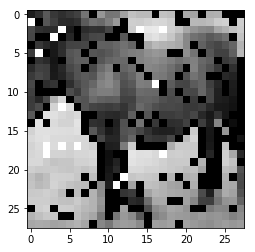

In [47]:
plt.imshow(img, cmap = 'gray')

Sve piksele na kojima je detektovan šum ćemo pretvoriti u bele. Tako možemo da vidimo sve crne šumove koje funkcija nije detektovala.

In [48]:
img[C==1] = 255

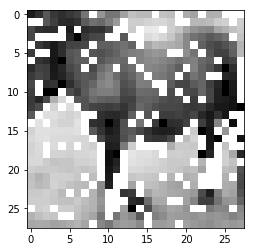

In [49]:
plt.imshow(img, cmap = 'gray')

### Uklanjanje detektovanog šuma

Za ukljanjanje detektovanog šuma koristićemo model linearne regresije. Krećemo se kroz matricu kvadratom dimenzije 5x5.

Za atribute uzimamo:
- 25 pojedinačnih piksela tog kvadrata
- razlike između susednih piksela vertikalno (4*5)
- razlike između susednih piksela horizontalno (5*4)
-  1

Ukupno 66 atributa i 66 parametara

In [199]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing

In [263]:
m = 100

In [264]:
x_cell_num = cube_size**2 + 2*cube_size*(cube_size-1)

In [265]:
x_cell_num

65

In [266]:
Y = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m))

In [267]:
Y_noisy = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m))

In [268]:
Y_pred = np.zeros(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),m))

Dizajn matrica

In [269]:
X_disp = np.zeros((x_cell_num + 1, (num_pix - (cube_size-1))*(num_pix - (cube_size-1)), m))

In [270]:
X_train = np.zeros((1,66))
Y_train = np.zeros((1))

In [271]:
for w in range(m):
    img_gray_red = img_gray[w, ((cube_size-1)//2):(num_pix-(cube_size-1)//2),\
                    ((cube_size-1)//2):(num_pix-(cube_size-1)//2)]
    img_gray_noisy_red = img_gray_noisy[w, ((cube_size-1)//2):(num_pix-(cube_size-1)//2),\
                    ((cube_size-1)//2):(num_pix-(cube_size-1)//2)]
    Y[:,w] = img_gray_red.reshape((num_pix-(cube_size-1))*(num_pix - (cube_size-1)))
    Y_noisy[:,w] = img_gray_noisy_red.reshape((num_pix-(cube_size-1))*(num_pix - (cube_size-1)))

    X_feature = np.zeros((x_cell_num, (num_pix-(cube_size-1))*(num_pix - (cube_size-1))))

    for i in range(((cube_size-1)//2),(num_pix-(cube_size-1)//2)):

        for j in range(((cube_size-1)//2),(num_pix-(cube_size-1)//2)):

            k = (num_pix - (cube_size-1))*(i - ((cube_size-1)//2))+(j-(cube_size-1)//2)

            cell_values = img_gray_noisy[w, (i - (cube_size-1)//2):(i + (cube_size-1)//2+1),\
                                         (j - (cube_size-1)//2):(j + (cube_size-1)//2+1)]

            X_feature[0:cube_size**2,k] = cell_values.reshape(cube_size**2)

            cell_diff_v = (img_gray_noisy[w,(i+1-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2+1)]-\
            img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2+1)])

            cell_diff_h = (img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j+1-(cube_size)//2):(j+(cube_size-1)//2+1)]-\
                        img_gray_noisy[w,(i-(cube_size-1)//2):(i+(cube_size-1)//2+1),\
                                         (j-(cube_size)//2):(j+(cube_size-1)//2)])   

            X_feature[cube_size**2:cube_size**2+cube_size*(cube_size-1),k] =\
                            cell_diff_v.reshape(cube_size*(cube_size-1))
            X_feature[cube_size**2+cube_size*(cube_size-1):, k] =\
                            cell_diff_v.reshape(cube_size*(cube_size-1))

    X_feature_mod = np.transpose(np.hstack((np.ones(((num_pix-(cube_size-1))*(num_pix - (cube_size-1)),1)),\
                                            np.transpose(X_feature))))
    X_disp[:,:,w] = X_feature_mod
    if w < 0.7*m:
        for j in range((num_pix-(cube_size-1))*(num_pix - (cube_size-1))):
            if Y_noisy[j,w] != Y[j,w]:
                X_train = np.vstack((X_train, X_feature_mod[:,j]))
                Y_train = np.hstack((Y_train, Y[j,w]))

In [272]:
X_train = X_train[1:,:]

In [273]:
X_train.shape

(54439, 66)

In [274]:
Y_train = Y_train[1:]

In [275]:
Y_train.shape

(54439,)

In [276]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [277]:
for w in range(m):
    Y_pred[:,w] = model.predict(X_disp[:,:,w].transpose())
    Y_noise_detect = noise_detector(img_gray_noisy[w].astype(int),cube_size)
    for j in range((num_pix-(cube_size-1))*(num_pix - (cube_size-1))):
        if np.transpose(Y_noise_detect.reshape((num_pix-(cube_size-1)),(num_pix - (cube_size-1)))).reshape(784)[j] == 0:
            Y_pred[j,w] = Y_noisy[j,w]

In [278]:
mse_train = metrics.mean_squared_error(Y[:,:int(0.7*m)], Y_pred[:,:int(0.7*m)])
mse_test = metrics.mean_squared_error(Y[:,int(0.7*m):], Y_pred[:,int(0.7*m):])
r2_train = metrics.r2_score(Y[:,:int(0.7*m)], Y_pred[:,:int(0.7*m)])
r2_test = metrics.r2_score(Y[:,int(0.7*m):], Y_pred[:,int(0.7*m):])

In [279]:
print('Train MSE: {}'.format(mse_train))
print('Test MSE: {}'.format(mse_test))
print('Train R2: {}'.format(r2_train))
print('Test R2: {}'.format(r2_test))

Train MSE: 453.7484519288712
Test MSE: 452.877975849269
Train R2: 0.7704350035817218
Test R2: 0.7824827102183912


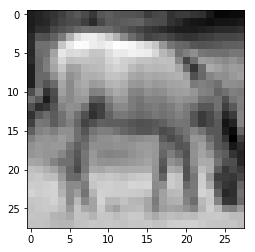

In [317]:
plt.imshow(Y[:,int(0.7*m)+17].reshape(28,28), cmap = 'gray')

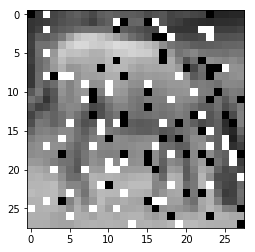

In [318]:
plt.imshow(Y_noisy[:,int(0.7*m)+17].reshape(28,28), cmap = 'gray')

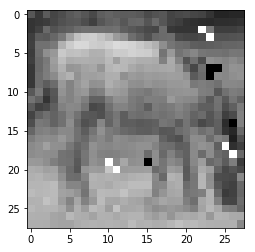

In [319]:
plt.imshow(Y_pred[:,int(0.7*m)+17].reshape(28,28), cmap = 'gray')

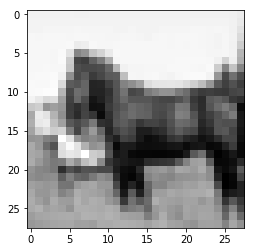

In [330]:
plt.imshow(Y[:,12].reshape(28,28), cmap = 'gray')

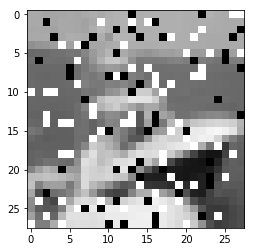

In [327]:
plt.imshow(Y_noisy[:,8].reshape(28,28), cmap = 'gray')

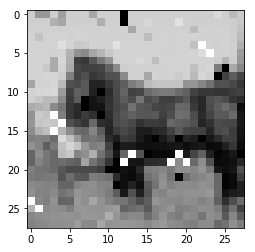

In [331]:
plt.imshow(Y_pred[:,12].reshape(28,28), cmap = 'gray')